## Ucitavanje baze

In [1]:
from funkcije import *

In [2]:
baza_location = biraj_bazu()

FileChooser(path='/home/zarko/PFE/prepoznavanje-emocija/lk-s-2023-prepoznavanje-emocija/baza/emodb/wav', filen…

In [3]:
baza = ucitaj_bazu(baza_location)

greska sa citanjem fajla:/home/zarko/PFE/prepoznavanje-emocija/lk-s-2023-prepoznavanje-emocija/baza/emodb/wav/newbaza


/home/zarko/PFE/prepoznavanje-emocija/lk-s-2023-prepoznavanje-emocija/funkcije.py:69: UserWarning: PySoundFile failed. Trying audioread instead.
  data, samplerate = librosa.load(fc.selected + filename)
/home/zarko/.local/lib/python3.9/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


In [4]:
#liste ficera 
hurstovi = []
duzine = [] 
odnostig = []
najduzaprica = []
mfccovi = []

zcrovi = [] #lokalni
pitchovi = []

zcr_prosek = [] #globalni
zcr_min = []
zcr_max = []
zcr_med = []
zcr_stdev = []

pitch_prosek = [] #globalni 
pitch_min = []
pitch_max = []
pitch_med = []
pitch_stdev = []

energije_short_term = []
energije_short_term_silence = []

frame_lenght = 480 
hop_lenght = frame_lenght//2


frame_length_tisina = 100
hop_length_tisina = frame_length_tisina//2
granica = 0.01

---
## hurst 

In [47]:

for sample in baza:
        h, c, val = compute_Hc(sample.data)
        hurstovi.append(h)

### duzine

In [48]:


for sample in baza:

     duzina = len(sample.data) * 1/sample.samplerate
        
     duzine.append(duzina) 

In [ ]:
### odnos govor prema tisina, max govor 

duzinatisine = []

#  frejmovano


for sample in baza:
      
     duzina = len(sample.data) * 1/sample.samplerate
     duzinatisinepriv = 0
     ptisina = 0
     trenprica = 0
     maxprica = 0
     for i in range (0, len(sample.data), hop_length_tisina):
          engparceta = sum(abs(sample.data[i:i+frame_length_tisina]**2))
          if engparceta < granica:
               trenprica = 0
               if ptisina == 0:
                    duzinatisinepriv = duzinatisinepriv + frame_length_tisina * 1/sample.samplerate
               else :
                    duzinatisinepriv = duzinatisinepriv + hop_length_tisina * 1/sample.samplerate
               ptisina = 1
          else: 
               ptisina = 0
               if trenprica == 0:
                    trenprica = frame_length_tisia * 1/sample.samplerate
               else :
                    trenprica = trenprica + hop_length_tisina * 1/sample.samplerate
               if trenprica > maxprica: maxprica = trenprica
     duzinatisine.append(duzinatisinepriv)
     najduzaprica.append(maxprica)

for i in range (0, len(duzine)):
     if duzinatisine[i] > 0:
          odnostig.append((duzine[i]-duzinatisine[i])/duzinatisine[i])
     else: odnostig.append(1)      

## MFCC
---

In [55]:
# data # citav audio fajl u nizu
# parcici[0] # prvi segment tog audio fajla(mozda nije prvi zbog tisine zapravo) --- NE
# prvi_seg # prvi segment koji nije tisina(trenutno su ostali pobrisani ovde)


for sample in baza:
    duzina = len(sample.data) * 1/sample.samplerate
            
    niz = librosa.feature.mfcc (y = sample.data, sr = sample.samplerate)
    mfccovi.append(niz) 
          
    

## ZCR
---

In [ ]:
## lokalni 


for sample in baza:
        #pitch = librosa.feature.zero_crossing_rate(data, frame_length = frame_length, hop_length = hop_length)
        zcr = librosa.feature.zero_crossing_rate(sample.data, frame_length = frame_length, hop_length = hop_length)
        #print(pitch)
        #print(zcr[0])         
        #plt.plot(zcr)      #vraca matricu iz nekog razloga, ali je sav sadrzaj u zcr[0] tkd cu samo to da uzimam
        zcrovi.append(zcr[0])

In [ ]:
## globalni 

for zcr in zcrovi:
    zcr_prosek.append(np.mean(zcr))
    zcr_min.append(np.min(zcr))
    zcr_max.append(np.max(zcr))
    zcr_med.append(np.median(zcr))
    zcr_stdev.append(np.std(zcr))
    #print (prosek, min, max, med, stdev)
    #break

## F0 --- pitch
---

In [5]:
#lokalni

for sample in baza:

    f0, voiced_flag, voiced_probs = librosa.pyin(sample.data,

                                                fmin=librosa.note_to_hz('C2'),

                                                fmax=librosa.note_to_hz('C7'), sr=sample.samplerate) #, frame_length=frame_len, hop_length=hop_len)
    pitchovi.append(f0)

In [50]:
## globalni 

pitch_prosek = []
pitch_min = []
pitch_max = []
pitch_med = []
pitch_stdev = []

for pitch_nn in pitchovi:
    pitch = pitch_nn[pitch_nn > -1]
    pitch_prosek.append(np.mean(pitch))
    pitch_min.append(np.min(pitch))
    pitch_max.append(np.max(pitch))
    pitch_med.append(np.median(pitch))
    pitch_stdev.append(np.std(pitch))
    #print (prosek, min, max, med, stdev)
    #break

## energija
---

In [17]:
# energija

energije_ukupne = []
energije_short_term = []
energije_short_term_silence = []


# short term energija, frejmovano
frame_length = frame_length_tisina # videcemo ali ovo ce ukloniti vise tisine tkd trebalo bi da utice 
hop_length = frame_length//2


for sample in baza:

    energy = sum(abs(sample.data**2))  ## ukupna energija fajla
    energije_ukupne.append(energy)

    energy_arr = np.array([
        sum(abs( sample.data[i:i+frame_length]**2))
        for i in range(0, len(sample.data), hop_length)])

    energije_short_term_silence.append(energy_arr)
    
for energija_kratko in energije_short_term_silence:
    energije_short_term.append(energija_kratko[energija_kratko > granica])

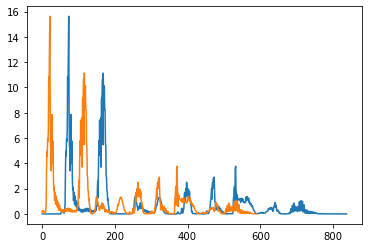

In [12]:
plt.plot(energije_short_term_silence[0])
plt.plot(energije_short_term[0])


### ucitavanje ficera u fajlove 

In [16]:
for sample in baza:
    name = sample.filename[:7]
    f = open ("ficeri/" + name + ".txt", "w")
    f.close()

In [ ]:
for sample in baza:
    f = open ("ficeri/" + name + ".txt", "a")
    f 
    f.close()